## Group ID
ADL Group 75


## Group Members
1. Ravindra Kumar Tholiya - 2023AA05124
2. Jahnavi Gali - 2023AA05684
3. Shivam Sahil - 2023AA05663
4. Chakshu - 2023aa05280

# Task 2: Task 2: Implement and train a SNGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.nn.utils import spectral_norm

In [ ]:
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]

In [3]:
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
# Config part -> We would need to tweak this block for different environments
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
checkpoint_dir = "drive/MyDrive/temp_db/2901/checkpoints"

Mounted at /content/drive


## Actual Implementation

In [6]:
# Hyperparameters
batch_size = 64
image_size = 32
channels = 3
latent_dim = 128  # a typical choice for SNGAN
num_epochs = 13   # adjust as needed
lr = 2e-4         # often higher for GANs
beta1 = 0.0
beta2 = 0.9

In [7]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [8]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 52.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
# Generator network (DCGAN-style)
class Generator(nn.Module):
    def __init__(self, latent_dim, channels, feature_map_size=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: channels x 32 x 32
        )

    def forward(self, z):
        # Reshape noise vector to (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), latent_dim, 1, 1)
        img = self.net(z)
        return img

In [10]:
# Discriminator network with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self, channels, feature_map_size=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: channels x 32 x 32
            spectral_norm(nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # State: feature_map_size x 16 x 16
            spectral_norm(nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_map_size*2) x 8 x 8
            spectral_norm(nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_map_size*4) x 4 x 4
            spectral_norm(nn.Conv2d(feature_map_size * 4, 1, 4, 1, 0, bias=False))
            # Output: 1 x 1 x 1
        )

    def forward(self, img):
        validity = self.net(img)
        return validity.view(-1)

In [11]:
# Initialize networks and optimizers
generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
# Checkpoint loading: only load files with "adl_assignment_2_sngan" in their name
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt') and "adl_assignment_2_sngan" in f]

def get_epoch_num(filename):
        return int(filename.split('epoch_')[1].split('.pt')[0])

if checkpoint_files:
    latest_checkpoint = sorted(checkpoint_files, key=get_epoch_num)[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

Loading checkpoint from drive/MyDrive/temp_db/2901/checkpoints/adl_assignment_2_sngan_checkpoint_epoch_16.pt


<ipython-input-12-753340eb035d>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [13]:
# Training loop with tqdm progress bar
print("Starting Training...")
for epoch in range(start_epoch, num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for i, (imgs, _) in enumerate(progress_bar):
        real_imgs = imgs.to(device)
        cur_batch = real_imgs.size(0)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        # Loss on real images
        real_validity = discriminator(real_imgs)
        d_real_loss = -torch.mean(real_validity)
        # Loss on fake images
        noise = torch.randn(cur_batch, latent_dim, device=device)
        fake_imgs = generator(noise)
        fake_validity = discriminator(fake_imgs.detach())
        d_fake_loss = torch.mean(fake_validity)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        epoch_d_loss += d_loss.item()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        noise = torch.randn(cur_batch, latent_dim, device=device)
        fake_imgs = generator(noise)
        g_loss = -torch.mean(discriminator(fake_imgs))
        g_loss.backward()
        optimizer_G.step()

        epoch_g_loss += g_loss.item()

        progress_bar.set_postfix({
            "D_loss": f"{d_loss.item():.4f}",
            "G_loss": f"{g_loss.item():.4f}"
        })

    # Save checkpoint after every epoch
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict()
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'adl_assignment_2_sngan_checkpoint_epoch_{epoch}.pt')
    torch.save(checkpoint, checkpoint_path)
    print(f"\nEpoch [{epoch+1}/{num_epochs}] - Checkpoint saved at {checkpoint_path}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss D: {epoch_d_loss/len(train_loader):.4f}, Avg Loss G: {epoch_g_loss/len(train_loader):.4f}")

Starting Training...


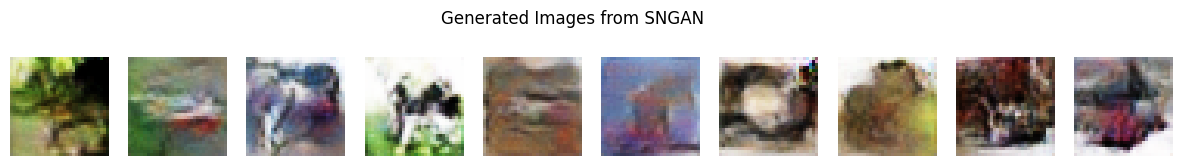

In [14]:
# Generate and display 10 new images
generator.eval()
n_samples = 10
with torch.no_grad():
    noise = torch.randn(n_samples, latent_dim, device=device)
    gen_imgs = generator(noise)
    gen_imgs = (gen_imgs + 1) / 2.0  # Denormalize from [-1,1] to [0,1]

fig, axs = plt.subplots(1, n_samples, figsize=(15,2))
for i in range(n_samples):
    axs[i].imshow(np.transpose(gen_imgs[i].cpu().numpy(), (1,2,0)))
    axs[i].axis('off')
plt.suptitle("Generated Images from SNGAN")
plt.show()

In [15]:
# Compute Inception Score (IS) and Fréchet Inception Distance (FID)
num_eval_samples = 1000
eval_batch = 50
gen_imgs_all = []
for _ in range(num_eval_samples // eval_batch):
    noise = torch.randn(eval_batch, latent_dim, device=device)
    gen_batch = generator(noise)
    gen_batch = (gen_batch + 1) / 2.0
    gen_imgs_all.append(gen_batch)
gen_imgs_all = torch.cat(gen_imgs_all, dim=0)

In [17]:
# Compute Inception Score
num_eval_samples = 200  # Reduced from 1000 to save memory
batch_size = 50
inception_metric = InceptionScore()  # On CPU

# Process in smaller batches
for i in range(0, num_eval_samples, batch_size):
    # Generate only one batch at a time
    current_batch_size = min(batch_size, num_eval_samples - i)
    noise = torch.randn(current_batch_size, latent_dim, device=device)
    with torch.no_grad():
        gen_batch = generator(noise)
        gen_batch = (gen_batch + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
        # Convert to uint8 as required by the metric
        gen_batch_uint8 = (gen_batch * 255).clamp(0, 255).to(torch.uint8)
        # Move to CPU immediately to free GPU memory
        gen_batch_uint8 = gen_batch_uint8.cpu()
        # Update metric with this batch only
        inception_metric.update(gen_batch_uint8)


# Compute score after all batches are processed
inception_score = inception_metric.compute()
print(f"Inception Score (IS): {inception_score[0].item():.4f} ± {inception_score[1].item():.4f}")

Inception Score (IS): 3.1989 ± 0.4387


In [18]:
# Prepare real images for FID: sample a subset of real CIFAR10 images
num_eval_samples = 200
batch_size = 50
fid_metric = FrechetInceptionDistance()

# First, process real images in batches
# Instead of loading all images at once
real_batch_indices = np.random.choice(len(train_dataset), num_eval_samples, replace=False)
real_dataloader = DataLoader(
    torch.utils.data.Subset(train_dataset, real_batch_indices),
    batch_size=batch_size,
    shuffle=False
)

# Process real images in batches
for batch_idx, (real_batch, _) in enumerate(real_dataloader):
    real_batch = (real_batch + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
    # Convert to uint8 as required by the metric
    real_batch_uint8 = (real_batch * 255).clamp(0, 255).to(torch.uint8).cpu()
    # Update metric with this batch only
    fid_metric.update(real_batch_uint8, real=True)

# Now process generated images in batches
for i in range(0, num_eval_samples, batch_size):
    current_batch_size = min(batch_size, num_eval_samples - i)
    noise = torch.randn(current_batch_size, latent_dim, device=device)
    with torch.no_grad():
        gen_batch = generator(noise)
        gen_batch = (gen_batch + 1) / 2.0  # Denormalize from [-1,1] to [0,1]
        # Convert to uint8 as required by the metric
        gen_batch_uint8 = (gen_batch * 255).clamp(0, 255).to(torch.uint8).cpu()
        # Update metric with this batch only
        fid_metric.update(gen_batch_uint8, real=False)

fid_score = fid_metric.compute()
print(f"Fréchet Inception Distance (FID): {fid_score.item():.4f}")

Fréchet Inception Distance (FID): 184.7956
